In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

In [2]:
def get_points(mean, cov, n):
    return np.random.multivariate_normal(mean, cov, n).T

In [3]:
def list2arr(l):
    return np.asarray(l, dtype=np.float32)

In [4]:
def plotable(X, ind = 0):
    x = []
    y = []
    for temp in X:
        x.append(temp[ind])
        y.append(temp[ind+1])
    x = list2arr(x)
    y = list2arr(y)
    return x, y

In [5]:
np.random.seed(0)

## Part A

In [6]:
# since control inputs are assumed to be zero for part A to C
def update_B(B, t):
    return B

In [7]:
def motion_model(X_0, A, B, t, mean, cov):
    X_t = [X_0] # X_i = [x_i, y_i, v_x_i, v_y_i]
    del_x, del_y, del_vx, del_vy = get_points(mean, cov, t)
    X_i = X_0.copy()
    for i in range(1, t+1):
        delta = list2arr([del_x[i-1], del_y[i-1], del_vx[i-1], del_vy[i-1]])
        X_i = np.dot(A, X_i) + B + delta
        X_t.append(X_i)
        B = update_B(B, i)
    return X_t

def observation_model(X_t, C, t, mean, cov):
    Z_t = [] # Z_i = [x_i, y_i]
    delta_zx, delta_zy = get_points(mean, cov, t+1)
    for i in range(0, t+1):
        Z_t.append(np.dot(C, X_t[i]) + [delta_zx[i], delta_zy[i]])
    return Z_t

In [8]:
A = [[1, 0, 1, 0], 
    [0, 1, 0, 1],
    [0, 0, 1, 0],
    [0, 0, 0, 1]]
A = list2arr(A)
B = list2arr([0, 0, 0, 0])
X_0 = list2arr([10, 10, 1, 1])
mean_ac = [0, 0, 0, 0]
cov_ac = [[1, 0, 0, 0],
      [0, 1, 0, 0],
      [0, 0, 1e-4, 0],
      [0, 0, 0, 1e-4]]
t = 200
X_t = motion_model(X_0, A, B, t, mean_ac, cov_ac)

C = list2arr([[1, 0, 0, 0], [0, 1, 0, 0]])
mean_ob = [0, 0]
cov_ob = [[100, 0], [0, 100]]
Z_t = observation_model(X_t, C, t, mean_ob, cov_ob)

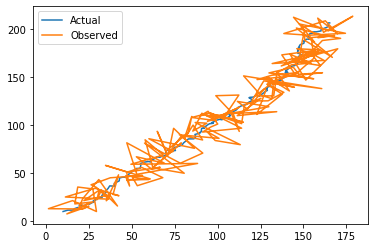

In [9]:
x, y = plotable(X_t)
plt.plot(x, y)
x, y = plotable(Z_t)
plt.plot(x, y)
plt.legend(['Actual', 'Observed'])
plt.show()

## Part B

In [10]:
np.random.seed(0)

In [11]:
def kalman_filter(mu_old, sigma_old, A, B, C, Q, R, z):
    mu_t_b = np.dot(A, mu_old) + B
    sigma_t_b = np.dot(np.dot(A, sigma_old), A.T) + R
    K = np.linalg.inv(np.dot(C, np.dot(sigma_t_b, C.T)) + Q)
    K = np.dot(sigma_t_b, np.dot(C.T, K))
    mu_t = mu_t_b + np.dot(K, z-np.dot(C, mu_t_b))
    sigma_t = np.dot(np.identity(K.shape[0])-np.dot(K, C), sigma_t_b)
    return mu_t, sigma_t

In [12]:
def kalman_trajectory(Z, X_0, A, B, C, Q, R, sigma, t):
    Mu_t = [X_0]
    for i in range(1, t+1):
        mu, sigma = kalman_filter(Mu_t[-1], sigma, A, B, C, Q, R, Z[i])
        Mu_t.append(mu)
        B = update_B(B, i)
    return Mu_t

In [13]:
sigma = 1e-4*np.identity(4)

Kalman_t = kalman_trajectory(Z_t, X_0, A, B, C, cov_ob, cov_ac, sigma, t) # Q = cov_ob, R = cov_ac

## Part C

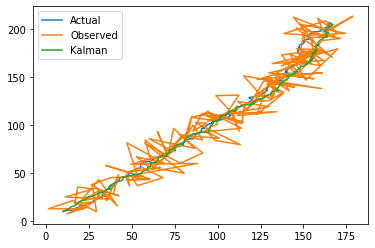

In [14]:
x, y = plotable(X_t)
plt.plot(x, y)
x, y = plotable(Z_t)
plt.plot(x, y)
x, y = plotable(Kalman_t)
plt.plot(x, y)
plt.legend(['Actual', 'Observed', 'Kalman'])
plt.show()

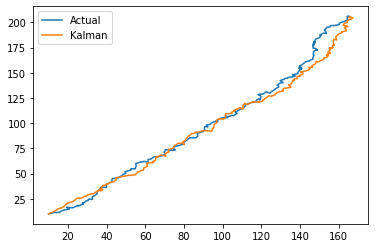

In [15]:
x, y = plotable(X_t)
plt.plot(x, y)
x, y = plotable(Kalman_t)
plt.plot(x, y)
plt.legend(['Actual', 'Kalman'])
plt.show()

In [16]:
def uncertainty_ellipse(x, y, xlim = None, ylim = None):
    def eigsorted(cov):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:,order]
    nstd = 2
    ax = plt.subplot(111)
    cov = np.cov(x, y)
    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))
    for nstd in [2]:
        w, h = 2 * nstd * np.sqrt(vals)
        ell = Ellipse(xy=(np.mean(x), np.mean(y)),
                      width=w, height=h,
                      angle=theta, color='black')
        ell.set_facecolor('none')
        ax.add_artist(ell)
    axes = plt.gca()
    if xlim is not None and ylim is not None:
        axes.set_xlim(xlim)
        axes.set_ylim(ylim)
    plt.scatter(x, y)
    plt.show()

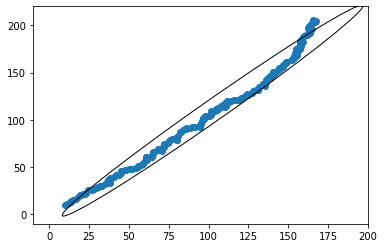

In [17]:
uncertainty_ellipse(x, y, [-10,200], [-10,220])

## Part D

In [18]:
np.random.seed(0)

In [19]:
def error(p, q):
    err = 0
    for i in range(len(p)):
        err += (p[i]-q[i])**2
    return math.sqrt(err)

In [20]:
def update_B(B, t):
    B[2] = math.sin(t)
    B[3] = math.cos(t)
    return B

In [21]:
B_0 = list2arr([0, 0, 0, 1])

t = 50
X_t = motion_model(X_0, A, B_0, t, mean_ac, cov_ac)
Z_t = observation_model(X_t, C, t, mean_ob, cov_ob)
Kalman_t = kalman_trajectory(Z_t, X_0, A, B_0, C, cov_ob, cov_ac, sigma, t)

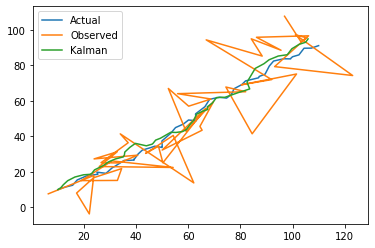

In [22]:
x, y = plotable(X_t)
plt.plot(x, y)
x, y = plotable(Z_t)
plt.plot(x, y)
x, y = plotable(Kalman_t)
plt.plot(x, y)
plt.legend(['Actual', 'Observed', 'Kalman'])
plt.show()

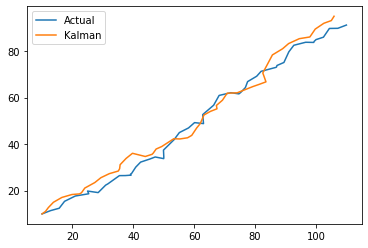

In [23]:
x, y = plotable(X_t)
plt.plot(x, y)
x, y = plotable(Kalman_t)
plt.plot(x, y)
plt.legend(['Actual', 'Kalman'])
plt.show()

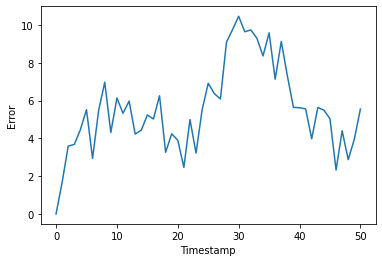

In [24]:
x_ac, y_ac = plotable(X_t)
x_kf, y_kf = plotable(Kalman_t)

errors = []
time_stamp = [] 
for i in range(len(x_ac)):
    errors.append(error([x_ac[i], y_ac[i]], [x_kf[i], y_kf[i]]))
    time_stamp.append(i)
plt.plot(time_stamp, errors) 
plt.ylabel('Error')
plt.xlabel('Timestamp')
plt.show()

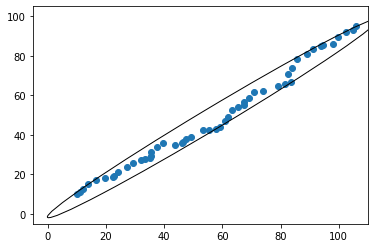

In [25]:
uncertainty_ellipse(x, y, [-5,110], [-5,105])

## Part E

In [26]:
def part_e(std_dev):
    np.random.seed(0)
    fig,a =  plt.subplots(1,2)
    plt.suptitle('Trajectory and Error for std_dev = ' + str(std_dev))
    B_0 = list2arr([0, 0, 0, 1])
    t = 50
    X_t = motion_model(X_0, A, B_0, t, mean_ac, cov_ac)
    cov_ob = (std_dev**2)*np.identity(2)
    Z_t = observation_model(X_t, C, t, mean_ob, cov_ob)
    Kalman_t = kalman_trajectory(Z_t, X_0, A, B_0, C, cov_ob, cov_ac, sigma, t)
    x, y = plotable(X_t)
    a[0].plot(x, y)
    x, y = plotable(Kalman_t)
    a[0].plot(x, y)
    a[0].legend(['Actual', 'Kalman'])
    a[1].set_xlabel('X')
    a[1].set_ylabel('Y')

    x_ac, y_ac = plotable(X_t)
    x_kf, y_kf = plotable(Kalman_t)
    errors = []
    time_stamp = [] 
    for i in range(len(x_ac)):
        errors.append(error([x_ac[i], y_ac[i]], [x_kf[i], y_kf[i]]))
        time_stamp.append(i)
    a[1].plot(time_stamp, errors)
    a[1].set_xlabel('Timestamp')
    a[1].set_ylabel('Error')
    figure = plt. gcf()
    figure. set_size_inches(14, 6)
    plt.savefig('part_e_' + str(std_dev) + '.jpg', dpi=200)
    plt.show()

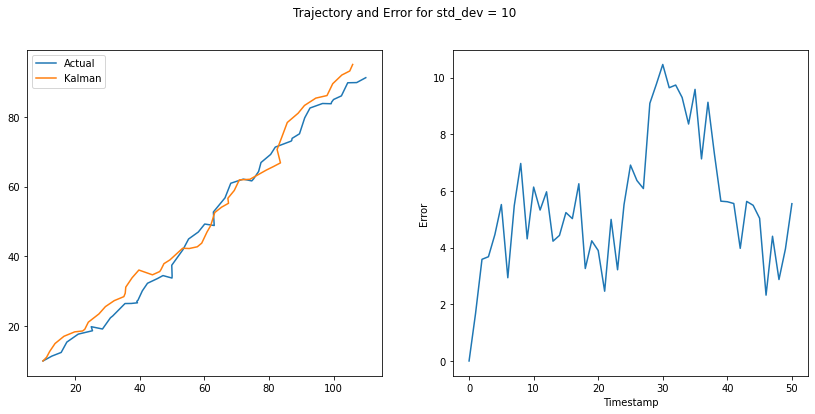

In [27]:
part_e(10)

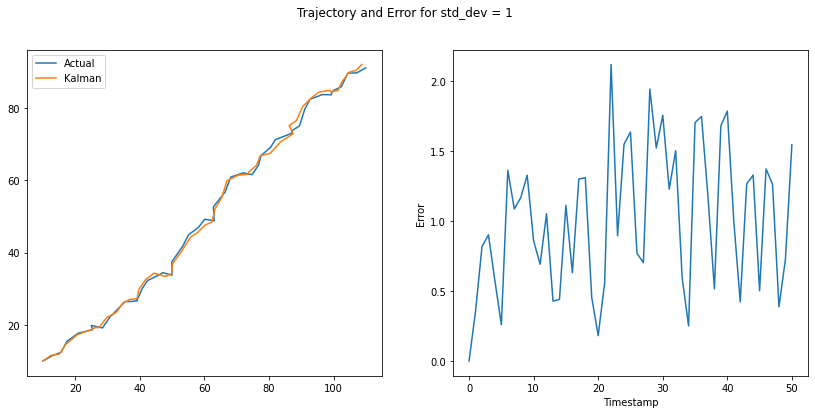

In [28]:
part_e(1)

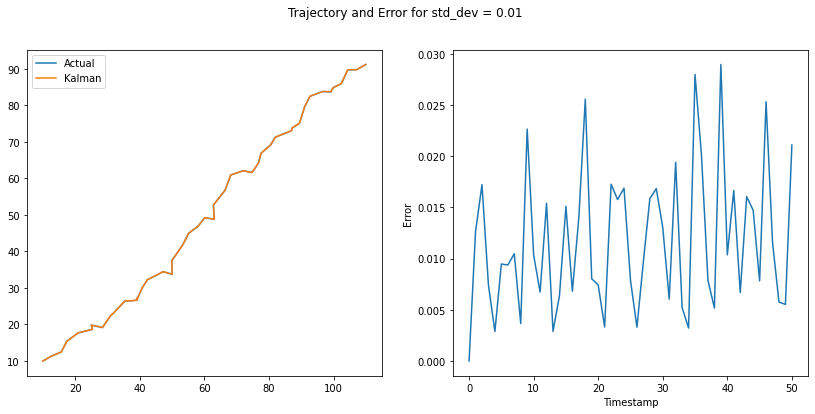

In [29]:
part_e(1e-2)

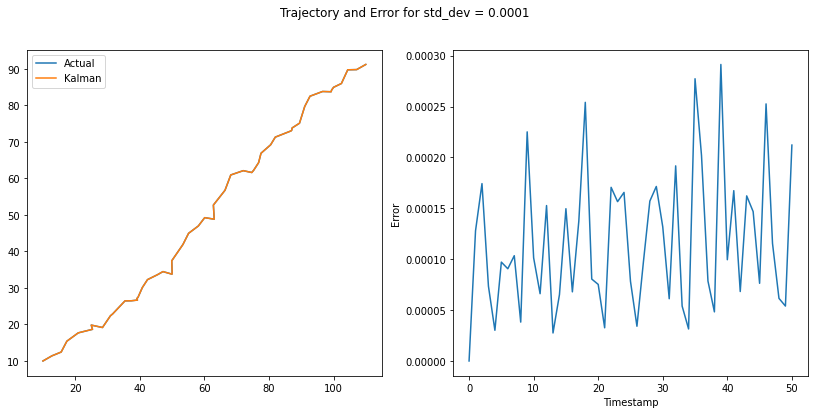

In [30]:
part_e(1e-4)

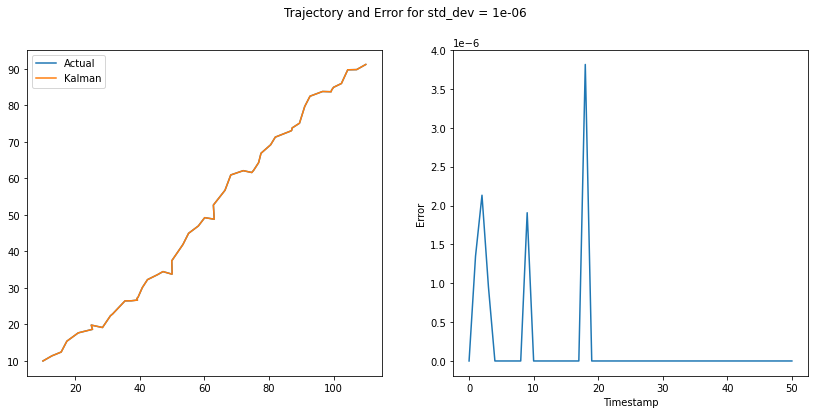

In [31]:
part_e(1e-6)

## Part F

In [32]:
np.random.seed(0)

In [33]:
B_0 = list2arr([0, 0, 0, 1])

t = 50
X_t = motion_model(X_0, A, B_0, t, mean_ac, cov_ac)
Z_t = observation_model(X_t, C, t, mean_ob, cov_ob)

sigma = 1e4*np.identity(4)
Kalman_t = kalman_trajectory(Z_t, X_0, A, B_0, C, cov_ob, cov_ac, sigma, t)

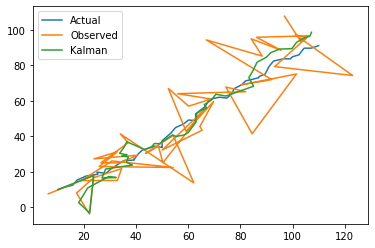

In [34]:
x, y = plotable(X_t)
plt.plot(x, y)
x, y = plotable(Z_t)
plt.plot(x, y)
x, y = plotable(Kalman_t)
plt.plot(x, y)
plt.legend(['Actual', 'Observed', 'Kalman'])
plt.show()

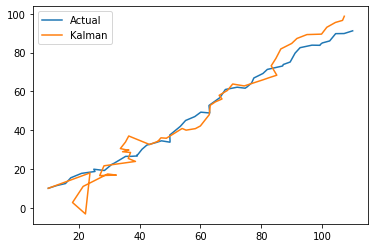

In [35]:
x, y = plotable(X_t)
plt.plot(x, y)
x, y = plotable(Kalman_t)
plt.plot(x, y)
plt.legend(['Actual', 'Kalman'])
plt.show()

## Part G

In [36]:
np.random.seed(0)

In [37]:
def kalman_filter_with_drop(mu_old, sigma_old, A, B, C, Q, R, z):
    mu_t_b = np.dot(A, mu_old) + B
    sigma_t_b = np.dot(np.dot(A, sigma_old), A.T) + R
    if z is None:
        return mu_t_b, sigma_t_b
    K = np.linalg.inv(np.dot(C, np.dot(sigma_t_b, C.T)) + Q)
    K = np.dot(sigma_t_b, np.dot(C.T, K))
    mu_t = mu_t_b + np.dot(K, z-np.dot(C, mu_t_b))
    sigma_t = np.dot(np.identity(K.shape[0])-np.dot(K, C), sigma_t_b)
    return mu_t, sigma_t

def kalman_trajectory_with_drop(Z, X_0, A, B, C, Q, R, sigma, t):
    Mu_t = [X_0]
    for i in range(1, t+1):
        mu, sigma = kalman_filter_with_drop(Mu_t[-1], sigma, A, B, C, Q, R, Z[i])
        Mu_t.append(mu)
        B = update_B(B, i)
    return Mu_t

In [38]:
B_0 = list2arr([0, 0, 0, 1])     # using the same sine-cosine policy as in D

t = 50
X_t = motion_model(X_0, A, B_0, t, mean_ac, cov_ac)
Z_t = observation_model(X_t, C, t, mean_ob, cov_ob)

# observations are dropped from t = 10 to 19 and t = 30 to 39
for i in range(10, 20):
    Z_t[i] = None
for i in range(30, 40):
    Z_t[i] = None

sigma = 1e-4*np.identity(4)    
Kalman_t = kalman_trajectory_with_drop(Z_t, X_0, A, B_0, C, cov_ob, cov_ac, sigma, t)

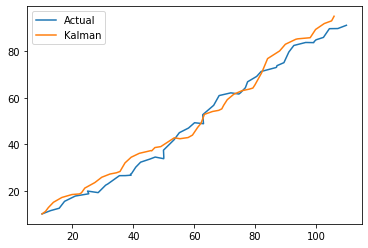

In [39]:
x, y = plotable(X_t)
plt.plot(x, y)
x, y = plotable(Kalman_t)
plt.plot(x, y)
plt.legend(['Actual', 'Kalman'])
plt.show()

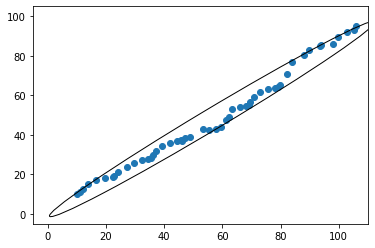

In [40]:
uncertainty_ellipse(x, y, [-5,110], [-5,105])

## Part H

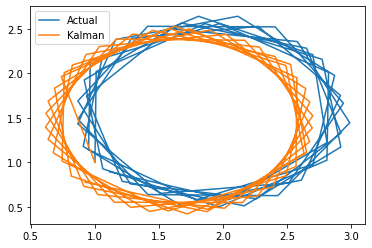

In [41]:
vx_ac, vy_ac = plotable(X_t, 2)
vx_kf, vy_kf = plotable(Kalman_t, 2)
plt.plot(vx_ac, vy_ac)
plt.plot(vx_kf, vy_kf)
plt.legend(['Actual', 'Kalman'])
plt.show()

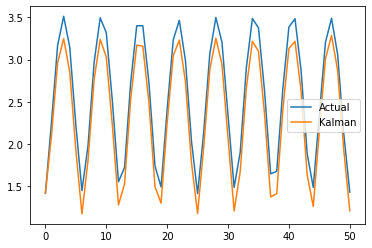

In [42]:
vel_ac = []
for i in range(len(vx_ac)):
    vel_ac.append(math.sqrt(vx_ac[i]**2 + vy_ac[i]**2))
vel_kf = []
for i in range(len(vx_kf)):
    vel_kf.append(math.sqrt(vx_kf[i]**2 + vy_kf[i]**2))
time_stamp = [i for i in range(0, len(vel_kf))]
plt.plot(time_stamp, vel_ac)
plt.plot(time_stamp, vel_kf)
plt.legend(['Actual', 'Kalman'])
plt.show()

## Part I

In [43]:
def _cover_zeroes(matrix, mask_matrix, row_cover, col_cover):
    while True:
        zero = True
        while zero:
            zero = _find_noncovered_zero(matrix, row_cover, col_cover)
            if not zero:
                break
            else:
                row = mask_matrix[zero[0]]
                row[zero[1]] = 2
                try:
                    index = row.index(1)
                except ValueError:
                    return zero
                row_cover[zero[0]] = True
                col_cover[index] = False
        m = min(_uncovered_values(matrix, row_cover, col_cover))
        for r, row in enumerate(matrix):
            for c, __ in enumerate(row):
                if row_cover[r]:
                    matrix[r][c] += m
                if not col_cover[c]:
                    matrix[r][c] -= m

def _find_noncovered_zero(matrix, row_cover, col_cover):
    for r, row in enumerate(matrix):
        for c, value in enumerate(row):
            if value == 0 and not row_cover[r] and not col_cover[c]:
                return (r, c)
    return None

def _uncovered_values(matrix, row_cover, col_cover):
    for r, row in enumerate(matrix):
        for c, value in enumerate(row):
            if not row_cover[r] and not col_cover[c]:
                yield value

def _find_star_in_col(mask_matrix, c):
    for r, row in enumerate(mask_matrix):
        if row[c] == 1:
            return (r, c)
    return None

def _find_prime_in_row(mask_matrix, r):
    for c, val in enumerate(mask_matrix[r]):
        if val == 2:
            return (r, c)
    return None

def minimize(matrix):
    n = len(matrix)
    for row in matrix:
        m = min(row)
        if m != 0:
            row[:] = map(lambda x: x - m, row)
    mask_matrix = [[0] * n for _ in matrix]
    row_cover = [False] * n
    col_cover = [False] * n
    for r, row in enumerate(matrix):
        for c, value in enumerate(row):
            if value == 0 and not row_cover[r] and not col_cover[c]:
                mask_matrix[r][c] = 1
                row_cover[r] = True
                col_cover[c] = True

    row_cover = [False] * n
    col_cover = [False] * n
    match_found = False

    while not match_found:
        for i in range(n):
            col_cover[i] = any(mrow[i] == 1 for mrow in mask_matrix)

        if all(col_cover):
            match_found = True
            continue
        else:
            zero = _cover_zeroes(matrix, mask_matrix, row_cover, col_cover)
            primes = [zero]
            stars = []
            while zero:
                zero = _find_star_in_col(mask_matrix, zero[1])
                if zero:
                    stars.append(zero)
                    zero = _find_prime_in_row(mask_matrix, zero[0])
                    stars.append(zero)
            for star in stars:
                mask_matrix[star[0]][star[1]] = 0
            for prime in primes:
                mask_matrix[prime[0]][prime[1]] = 1
            for r, row in enumerate(mask_matrix):
                for c, val in enumerate(row):
                    if val == 2:
                        mask_matrix[r][c] = 0

            row_cover = [False] * n
            col_cover = [False] * n
    solution = []
    for r, row in enumerate(mask_matrix):
        for c, val in enumerate(row):
            if val == 1:
                solution.append((r, c))
    return solution

def hungarian_algorithm(l):
    matrix = [[y for y in x] for x in l]
    m = max(max(row) for row in matrix)
    matrix = [[m-y for y in x] for x in l]
    return minimize(matrix)

In [44]:
def motion_model(X_0, A, B, t, mean, cov):
    X_t = [X_0] # X_i = [x_i, y_i, v_x_i, v_y_i]
    del_x, del_y, del_vx, del_vy = get_points(mean, cov, t)
    X_i = X_0.copy()
    for i in range(1, t+1):
        delta = list2arr([del_x[i-1], del_y[i-1], del_vx[i-1], del_vy[i-1]])
        X_i = np.dot(A, X_i) + B + delta
        X_t.append(X_i)
    return X_t

def kalman_filter(mu_old, sigma_old, A, B, C, Q, R, z):
    mu_t_b = np.dot(A, mu_old) + B
    sigma_t_b = np.dot(np.dot(A, sigma_old), A.T) + R
    K = np.linalg.inv(np.dot(C, np.dot(sigma_t_b, C.T)) + Q)
    K = np.dot(sigma_t_b, np.dot(C.T, K))
    mu_t = mu_t_b + np.dot(K, z-np.dot(C, mu_t_b))
    sigma_t = np.dot(np.identity(K.shape[0])-np.dot(K, C), sigma_t_b)
    return mu_t, sigma_t

B = list2arr([0, 0, 0, 0])
B_0 = list2arr([0, 0, 0, 0])

In [45]:
from numpy.random import randint as rand
from numpy.random import choice

def random_sample(a, b):
    return (b-a)*np.random.random() + a

def get_actual_paths(n, noise_mean, noise_cov):
    X_0 = []
    for i in range(n):
        pos = [rand(-199, 200), rand(-199, 200)]
        vel = [choice([1, -1, 2, -2]), choice([1, -1, 2, -2])]
        X_0.append(list2arr(pos + vel))
        
    t = 50
    X_t = [[0 for j in range(n)] for i in range(t+1)]
    for i in range(n):
        temp = motion_model(X_0[i], A, B_0, t, noise_mean[i], noise_cov[i])
        for j in range(len(temp)):
            X_t[j][i] = temp[j]
        X_t[0][i] = X_0[i]
    return X_t

def initialisation(n):
    # motion noise
    noise_mean = []
    noise_cov = []
    for i in range(n):
        temp = []
        for j in range(4):
            temp.append(random_sample(-1, 1))
        temp = list2arr(temp)
        noise_mean.append(temp)
        temp = np.zeros((4, 4))
        for j in range(4):
            temp[j][j] = random_sample(1e-4, 1)
        noise_cov.append(temp)
    noise_motion = [noise_mean, noise_cov]
    # actual paths followed
    X_t = get_actual_paths(n, noise_mean, noise_cov)
    # beliefs
    mu_bel = []
    sigma_bel = []
    for i in range(n):
        mu_bel.append(X_t[0][i])
        sigma_bel.append(random_sample(1e-4, 1e-1)*np.identity(4))
    kalman_belief = [mu_bel, sigma_bel]
    return noise_motion, X_t, kalman_belief

def one_observation(X, C, mean, cov):
    delta_zx, delta_zy = get_points(mean, cov, 1)
    return np.dot(C, X) + [delta_zx[0], delta_zy[0]]

def get_score(p, q):
    err = error(p, q)
    return 1/(err + 1e-10)

def get_expected_positions(n, X, kalman_belief, R):
    Z = []
    for i in range(len(X)):
        Z.append(one_observation(X[i], C, mean_ob, cov_ob))
    np.random.shuffle(Z) # bcoz we don't know which obs is for which object

    scores = [[0 for j in range(n)] for i in range(n)]
    kp = [[0 for j in range(n)] for i in range(n)]
    mu_bel = kalman_belief[0]
    sigma_bel = kalman_belief[1]
    for i in range(n):
        for j in range(n):
            mu_temp, sigma_temp = kalman_filter(mu_bel[i], sigma_bel[i], A, B, C, cov_ob, R[i], Z[j])
            kp[i][j] = mu_temp
            scores[i][j] = get_score(X[i][0:2], kp[i][j])
    res = hungarian_algorithm(scores)
    prediction = [0]*n
    for x in res:
        obj, pred_ind = x
        prediction[obj] = kp[obj][pred_ind]
    
    for i in range(n):
        mu_bel[i], sigma_bel[i] = kalman_filter(mu_bel[i], sigma_bel[i], A, B, C, cov_ob, R[i], Z[pred_ind])
    kalman_belief = [mu_bel, sigma_bel]
    return kalman_belief, prediction

def multi_agent(n): 
    # noise_motion = [noise_mean, noise_cov]
    noise_motion, X_t, kalman_belief = initialisation(n)
    # these will be same bcoz same sensor
    prediction = []
    for x in X_t:
        kalman_belief, pos = get_expected_positions(n, x, kalman_belief, noise_motion[1])
        prediction.append(pos)
    return X_t, prediction    

A = [[1, 0, 1, 0], 
    [0, 1, 0, 1],
    [0, 0, 1, 0],
    [0, 0, 0, 1]]
A = list2arr(A)
C = list2arr([[1, 0, 0, 0], [0, 1, 0, 0]])
mean_ob = [0, 0]
cov_ob = [[0.01, 0], [0, 0.01]]

In [46]:
def subset(a, index_ob, ax):
    l = []
    for i in range(len(a)):
        l.append(a[i][index_ob][ax])
    return l

def plot(actual, prediction):
    n = len(actual[0])
    legend = []
    for i in range(n):
        x_ac, y_ac = subset(actual, i, 0), subset(actual, i, 1)
        plt.plot(x_ac, y_ac)
        x_pr, y_pr = subset(prediction, i, 0), subset(prediction, i, 1)
        plt.plot(x_pr, y_pr)
        legend += ['Actual ' + str(i), 'Estimated ' + str(i)]
    plt.legend(legend, bbox_to_anchor=(1.05, 1))
    plt.title(str(n) + ' agents, ' + str(cov_ob[0][0]) + ' variance')
    plt.savefig('part_i_' + str(n) + '_' + str(cov_ob[0][0]) +'.jpg', dpi=200, bbox_inches='tight')
    plt.show()

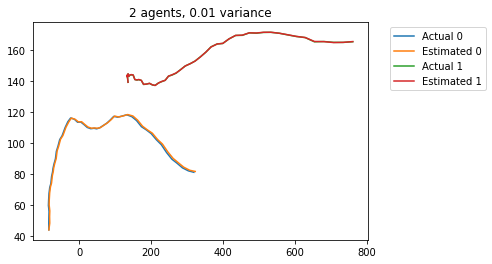

In [47]:
np.random.seed(0)
actual, prediction = multi_agent(2)
plot(actual, prediction)

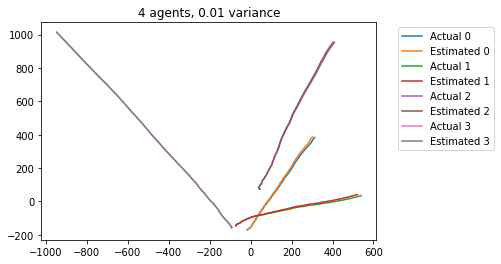

In [48]:
np.random.seed(0)
actual, prediction = multi_agent(4)
plot(actual, prediction)

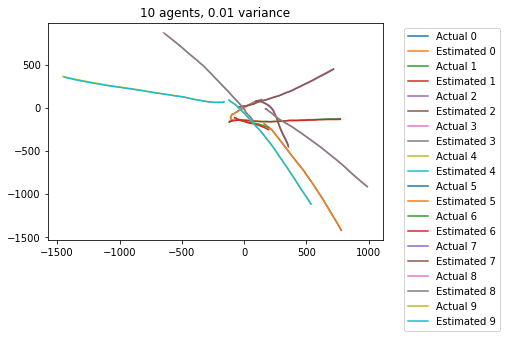

In [49]:
np.random.seed(0)
actual, prediction = multi_agent(10)
plot(actual, prediction)

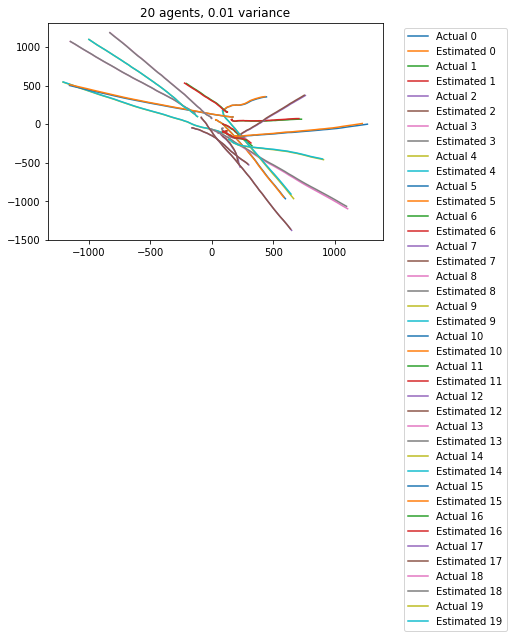

In [50]:
np.random.seed(0)
actual, prediction = multi_agent(20)
plot(actual, prediction)

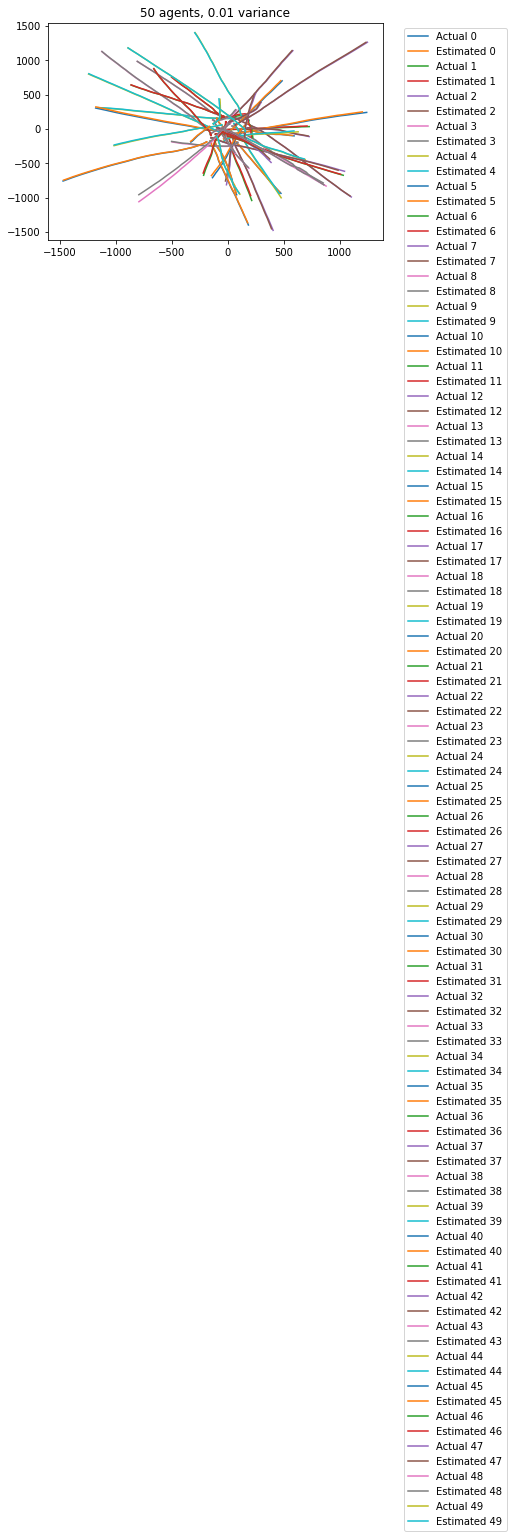

In [51]:
np.random.seed(0)
actual, prediction = multi_agent(50)
plot(actual, prediction)

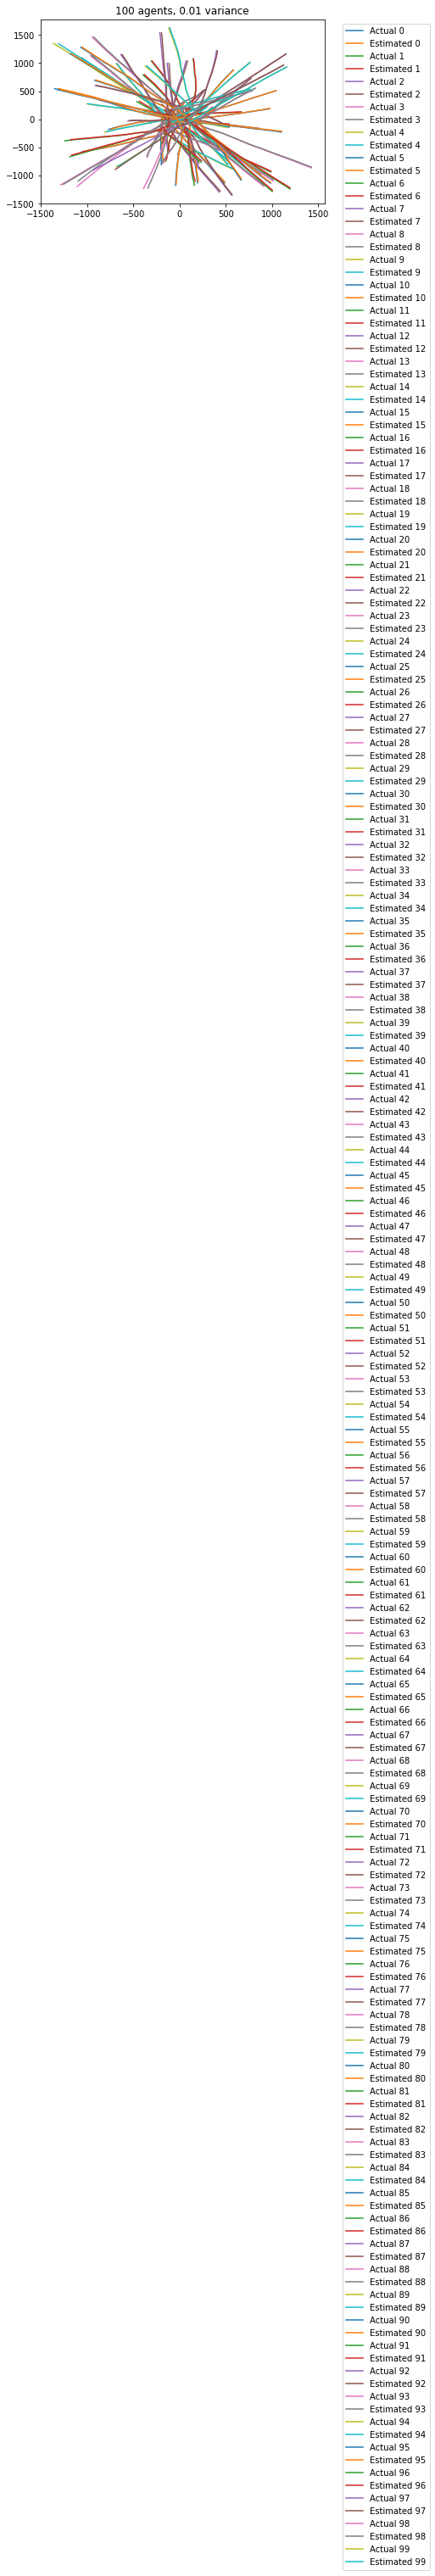

In [52]:
np.random.seed(0)
actual, prediction = multi_agent(100)
plot(actual, prediction)

In [53]:
# increase noise in observations
cov_ob = [[0.1, 0], [0, 0.1]]

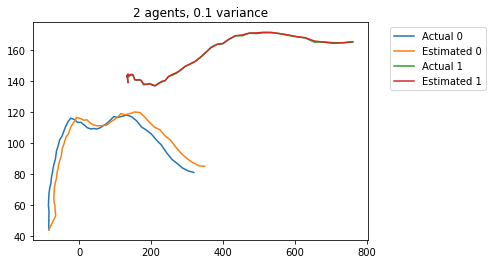

In [54]:
np.random.seed(0)
actual, prediction = multi_agent(2)
plot(actual, prediction)

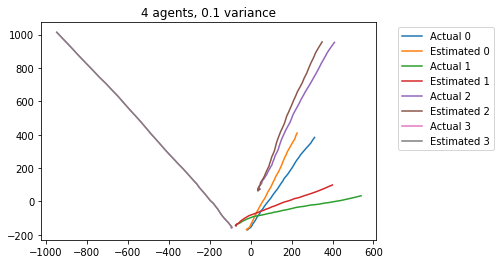

In [55]:
np.random.seed(0)
actual, prediction = multi_agent(4)
plot(actual, prediction)

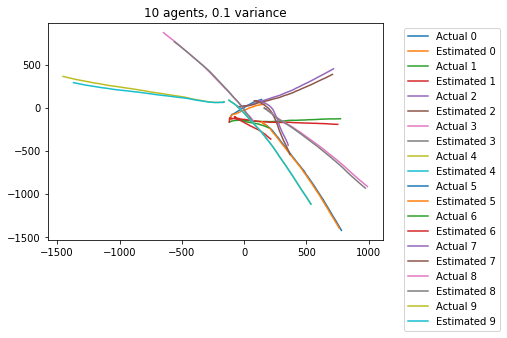

In [56]:
np.random.seed(0)
actual, prediction = multi_agent(10)
plot(actual, prediction)

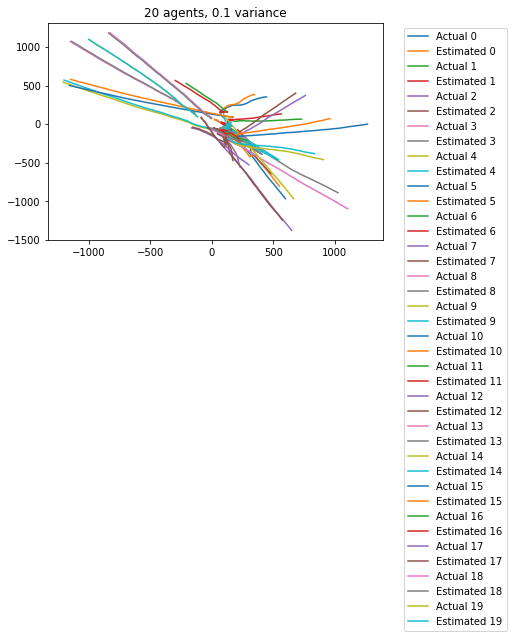

In [57]:
np.random.seed(0)
actual, prediction = multi_agent(20)
plot(actual, prediction)